# MPI calibration of a Grid5000 cluster

## Data exploration

In [1]:
import os
import zipfile
import yaml
import pandas
import io
import plotnine
plotnine.options.figure_size = (12, 8)
from plotnine import *
import matplotlib.pyplot as plt
import pytree
print(f'pytree {pytree.__version__}')
print(f'pytree {pytree.__git_version__}')

remote_archive   = 'large_calibration/2/grenoble_2020-08-18_1944780.zip'
loopback_archive = 'large_calibration/2/grenoble_2020-08-18_1944779.zip'
ringrong_archive = 'ring/3/grenoble_2020-08-19_1944895.zip'
ringrong_archive = 'ring/3/grenoble_2020-08-19_1944943.zip'

threshold = 64000  # "semantic" breakpoint, found with another script

# I really hate that we have to define these two values:
expected_bandwidth = 1e11/8
expected_latency   = 1e-7

expected_loopback_bandwidth = 2e11/8
expected_loopback_latency = 1e-7

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'), Loader=yaml.BaseLoader)['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name), Loader=yaml.BaseLoader)
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

def load_experiment(zip_name, exp_name=None):
    result = extract_zip(zip_name)
    # Special processing for the Pingpong dataset
    df_pingpong = result['exp/exp_PingPong.csv']
    pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
    pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
    df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                       msg_size = pingpong_send.msg_size,
                       start    = pingpong_send.start,
                       duration = pingpong_recv.duration + pingpong_send.duration
                  ))
    result = {
        'pingpong': df_pingpong,
        'send'  : pingpong_send,
        'isend' : result['exp/exp_Isend.csv'],
        'recv'  : result['exp/exp_Recv.csv'],
        'wtime' : result['exp/exp_Wtime.csv'],
        'test'  : result['exp/exp_Test.csv'],
        'iprobe': result['exp/exp_Iprobe.csv'],
    }
    if exp_name is not None:
        for df in result.values():
            df['experiment'] = exp_name
    return result

pytree 0.0.6
pytree daeffcbfbfb10dc9d69044bb110f965ab4e4e042


In [2]:
def load_ringrong(zip_name):
    df = read_csv(zip_name, 'result.csv').reset_index()
    df['msg_size'] = df['size']
    df.drop('size', inplace=True, axis=1)
    df['sub_id'] = df['index'] // 2 # identifying the MPI_Send and MPI_Recv that are part of a same ping-pong
    df['op_kind'] = df['sub_id'] % 2 # each rank makes two distincts ping-pong: one recv-send with the previous rank and one send-recv with the next rank
    df.loc[df['op_kind'] == 0, 'op_kind'] = 'recv-send'
    df.loc[df['op_kind'] == 1, 'op_kind'] = 'send-recv'
    remote_next = {31, 63}
    remote_prev = {0, 32}
    df.loc[df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'loopback'
    df.loc[df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'loopback'
    df_send = df[df['function'] == 'MPI_Send']
    df_recv = df[df['function'] == 'MPI_Recv']
    df_ringrong = df_send.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']).join(df_recv.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']), lsuffix='_send', rsuffix='_recv').reset_index()
    df_ringrong['duration'] = df_ringrong['duration_send'] + df_ringrong['duration_recv']
    return {
        'ringrong': df_ringrong,
        'send': df_send,
        'recv': df_recv
    }

ring = load_ringrong(ringrong_archive)

In [3]:
remote   = load_experiment(remote_archive, exp_name='remote')
loopback = load_experiment(loopback_archive, exp_name='loopback')

### First visualization of the pingpong durations

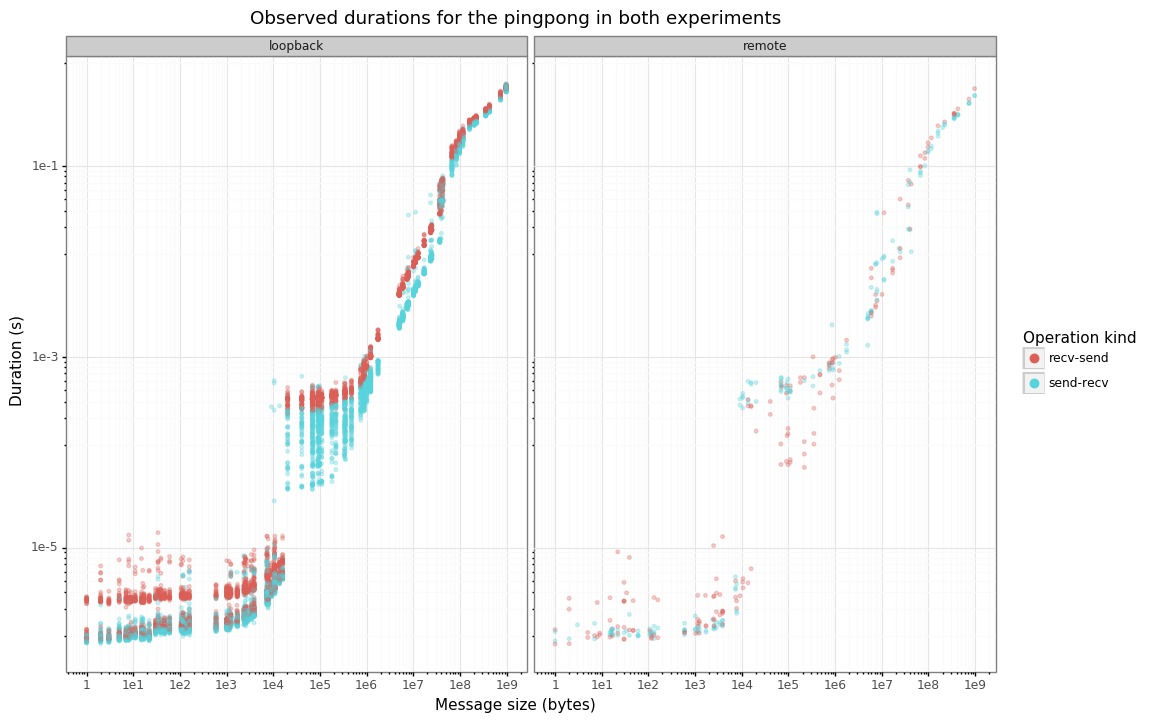

<ggplot: (-9223363245622726270)>

In [4]:
tmp=ring['ringrong']
tmp['bandwidth'] = 2*tmp['msg_size'] / tmp['duration'] * 1e-9
plot = (ggplot(tmp.sample(n=10000))
    + aes(x='msg_size', y='duration', color='op_kind')
    + geom_point(alpha=0.3, size=1)
    + scale_x_log10(breaks=[10**n for n in range(10)])
    + scale_y_log10()
    + theme_bw()
    + ggtitle('Observed durations for the pingpong in both experiments')
    + labs(x='Message size (bytes)', y='Duration (s)', color='Operation kind')
    + guides(color = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
    + facet_wrap('experiment')
)
plot

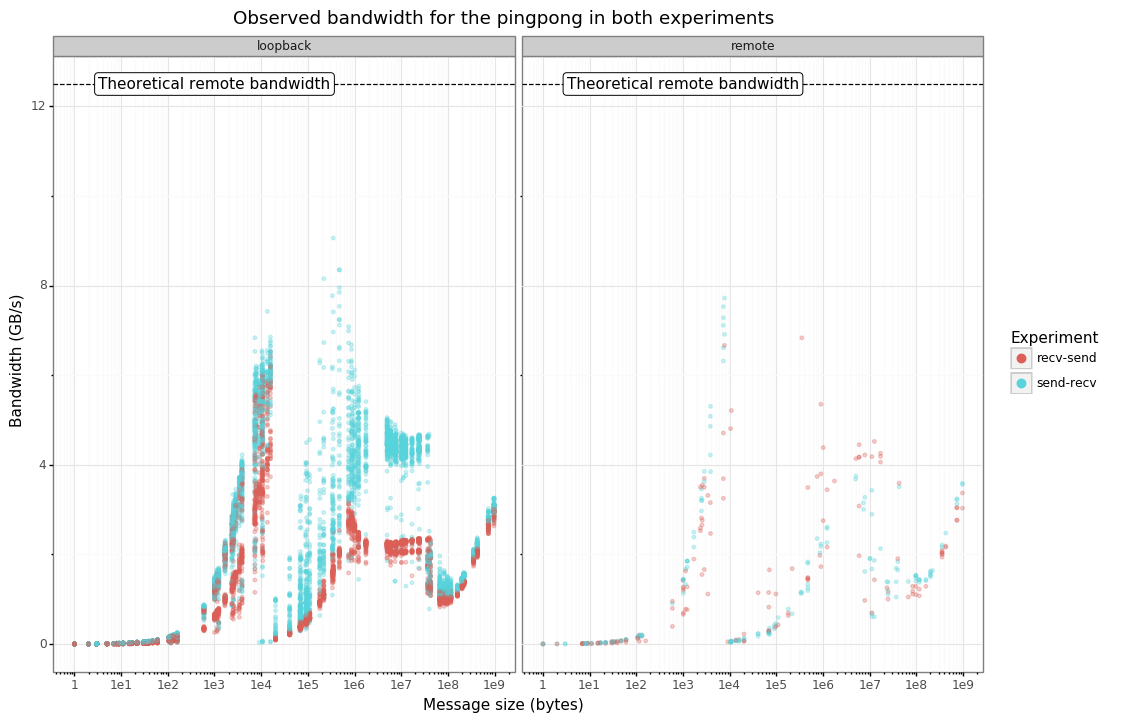

<ggplot: (-9223363245622759648)>

In [5]:
plot = (ggplot(tmp.sample(n=10000))
    + aes(x='msg_size', y='bandwidth', color='op_kind')
    + geom_hline(yintercept=expected_bandwidth*1e-9, linetype='dashed')
    + annotate('label', label='Theoretical remote bandwidth', x=1000, y=expected_bandwidth*1e-9)
    + geom_point(alpha=0.3, size=1)
    + scale_x_log10(breaks=[10**n for n in range(10)])
    + theme_bw()
    + ggtitle('Observed bandwidth for the pingpong in both experiments')
    + labs(x='Message size (bytes)', y='Bandwidth (GB/s)', color='Experiment')
    + guides(color = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
    + facet_wrap('experiment')
)
plot

221569716


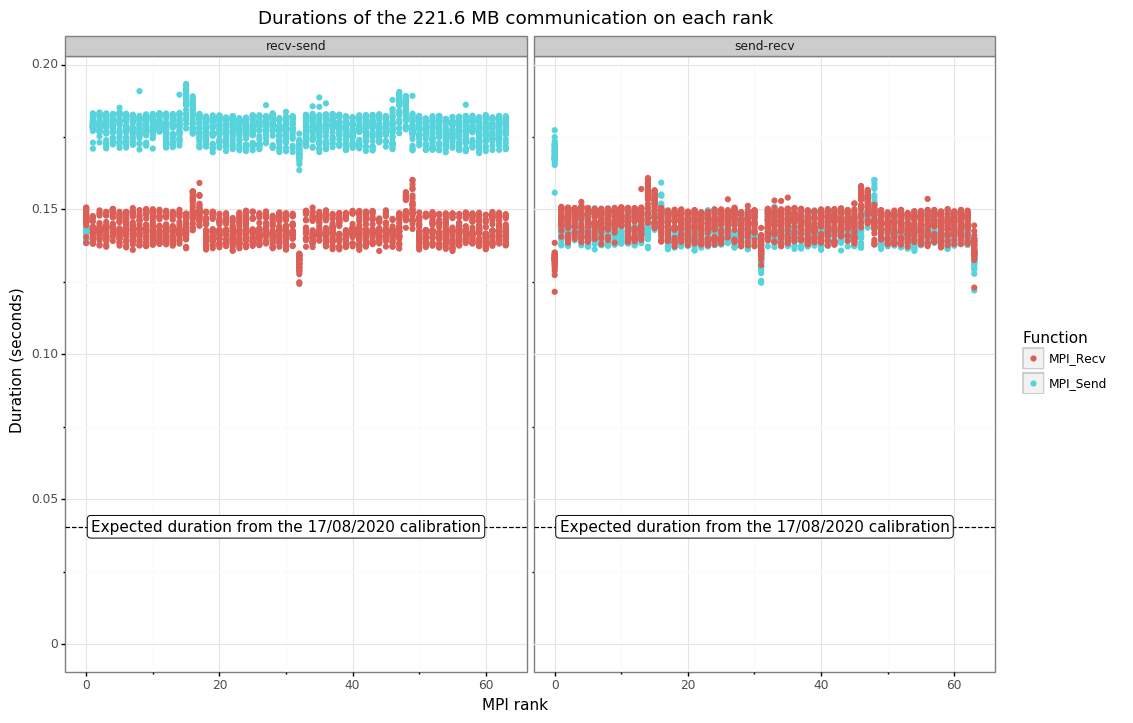

<ggplot: (-9223363245724315006)>

In [6]:
tmp = pandas.concat([ring['send'], ring['recv']])
hpl_s = 2.56e8
size = tmp[(tmp['msg_size'] > hpl_s*0.7) & (tmp['msg_size'] < hpl_s*1.3)]['msg_size'].max()
print(size)

bw  = 25*1e9
lat = 0.1*1e-6
bw_factor = 0.219
lat_factor = 0
theoretical_duration = size/(bw*bw_factor) + lat*lat_factor

(ggplot(tmp[tmp['msg_size'] == size])
    + aes(x='rank', y='duration', color='function')
    + geom_point() 
    + theme_bw()
    + expand_limits(y=0)
    + facet_wrap('op_kind')
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + labs(x='MPI rank', y='Duration (seconds)', color='Function')
    + annotate('label', x=30, y=theoretical_duration, label='Expected duration from the 17/08/2020 calibration')
    + ggtitle(f'Durations of the {size*1e-6:.1f} MB communication on each rank')
)

### Monitoring

In [7]:
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction

c0a430e3a498fc690b6244ca9909444040c28128


In [8]:
dataframes = []
for mode, archive in [('ringrong', ringrong_archive)]:
    monitoring = archive_extraction.read_monitoring(archive)
    monitoring['mode'] = mode
    dataframes.append(monitoring)
monitoring = pandas.concat(dataframes)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

1026752


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,mode,date,real_start_time,cpu_id,in_exp,hostname
0,0.001873,dahu,25,1944943,1597849733,6739f00b7ea525b20ae6f3cdd3202cc3835def4cbd026b...,1.114471,0,0,frequency,58.647685,8082.47245,ringrong,2020-08-19 15:08:53,1.597857e+09,25:0,False,dahu-25
1,1.010318,dahu,25,1944943,1597849733,6739f00b7ea525b20ae6f3cdd3202cc3835def4cbd026b...,2.242144,0,0,frequency,58.647685,8082.47245,ringrong,2020-08-19 15:08:53,1.597857e+09,25:0,False,dahu-25
2,2.019142,dahu,25,1944943,1597849733,6739f00b7ea525b20ae6f3cdd3202cc3835def4cbd026b...,3.087963,0,0,frequency,58.647685,8082.47245,ringrong,2020-08-19 15:08:53,1.597857e+09,25:0,False,dahu-25
3,3.027693,dahu,25,1944943,1597849733,6739f00b7ea525b20ae6f3cdd3202cc3835def4cbd026b...,3.103344,0,0,frequency,58.647685,8082.47245,ringrong,2020-08-19 15:08:53,1.597857e+09,25:0,False,dahu-25
4,4.036431,dahu,25,1944943,1597849733,6739f00b7ea525b20ae6f3cdd3202cc3835def4cbd026b...,1.379022,0,0,frequency,58.647685,8082.47245,ringrong,2020-08-19 15:08:53,1.597857e+09,25:0,False,dahu-25


In [9]:
monitoring[monitoring.in_exp].groupby(['mode', 'hostname', 'cpu', 'kind'])[['value']].mean()

value
mode     hostname cpu kind                  
ringrong dahu-25  0   frequency     1.923856
                      temperature  77.929045
                  1   frequency     1.923337
                      temperature  53.943556
         dahu-27  0   frequency     1.923794
                      temperature  71.806078
                  1   frequency     1.923429
                      temperature  59.708663

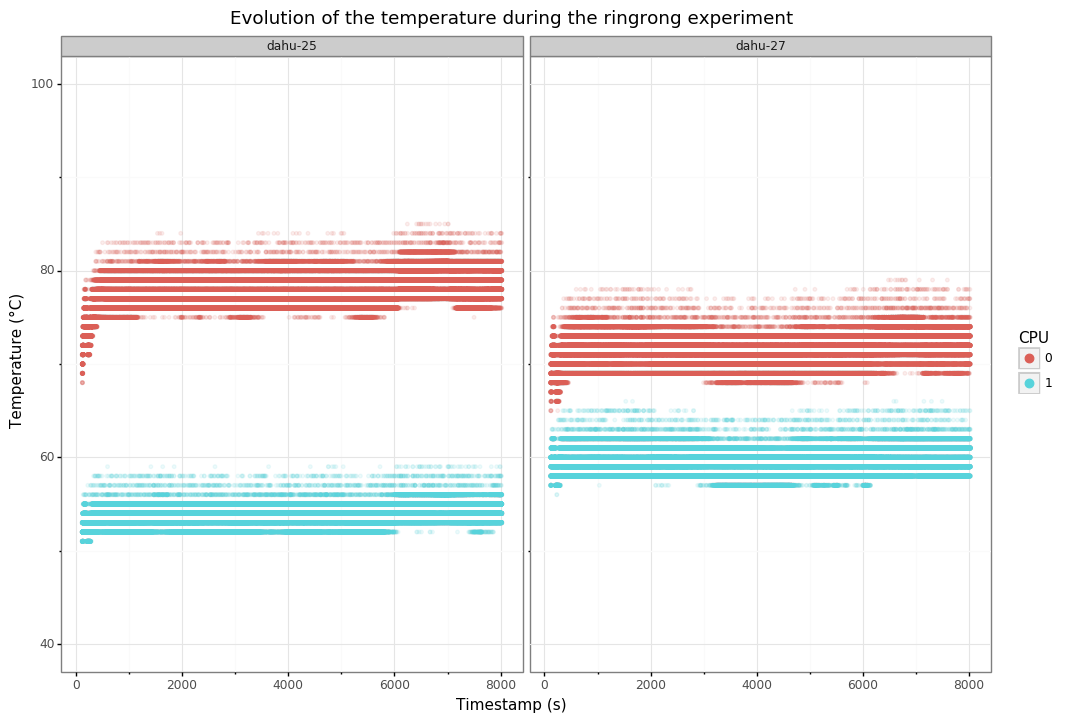

<ggplot: (-9223363245722441461)>


In [10]:
for mode in sorted(monitoring['mode'].unique()):
    print(ggplot(monitoring[(monitoring.in_exp) & (monitoring['mode'] == mode) & (monitoring.kind == 'temperature')])
        + aes(x='timestamp', y='value', color='factor(cpu)')
        + geom_point(alpha=0.1, size=1)
        + theme_bw()
        + labs(x='Timestamp (s)', y='Temperature (°C)', color='CPU')
        + facet_wrap('hostname')
        + ggtitle(f'Evolution of the temperature during the {mode} experiment')
        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + expand_limits(y=[40, 100])
    )

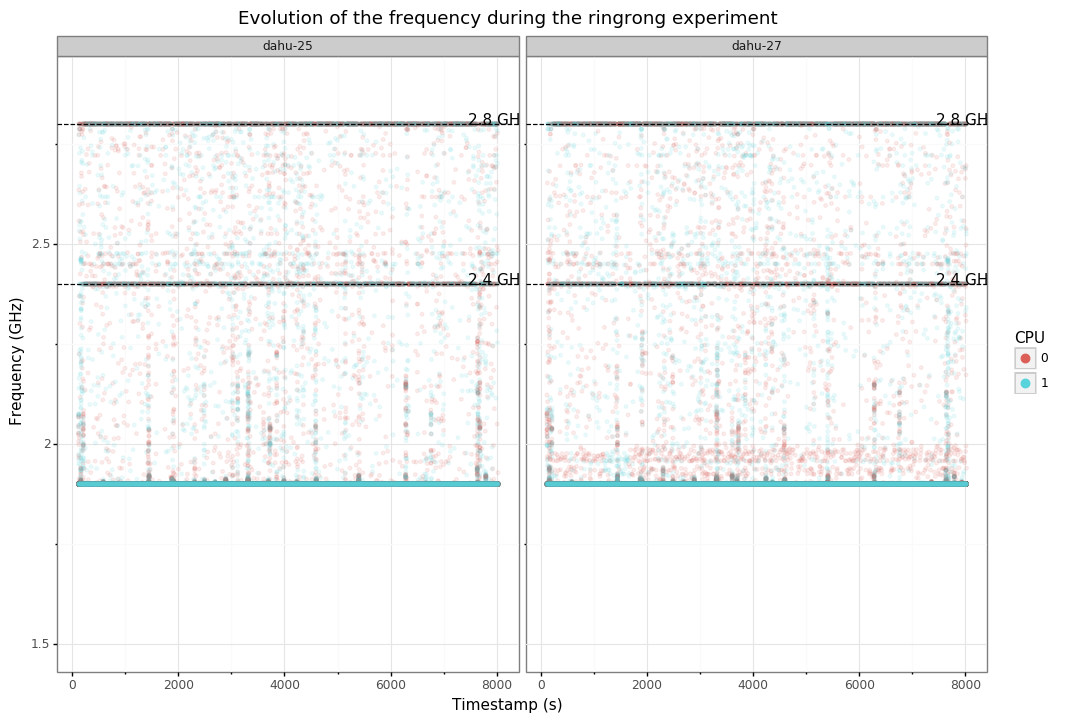

<ggplot: (8791094614753)>


In [11]:
for mode in sorted(monitoring['mode'].unique()):
    print(ggplot(monitoring[(monitoring.in_exp) & (monitoring['mode'] == mode) & (monitoring.kind == 'frequency')])
        + aes(x='timestamp', y='value', color='factor(cpu)')
        + geom_point(alpha=0.1, size=1)
        + theme_bw()
        + labs(x='Timestamp (s)', y='Frequency (GHz)', color='CPU')
        + facet_wrap('hostname')
        + ggtitle(f'Evolution of the frequency during the {mode} experiment')
        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + geom_hline(yintercept=2.4, linetype='dashed')
        + annotate('text', label='2.4 GHz', x=monitoring[monitoring.in_exp].timestamp.max(), y=2.41)
        + geom_hline(yintercept=2.8, linetype='dashed')
        + annotate('text', label='2.8 GHz', x=monitoring[monitoring.in_exp].timestamp.max(), y=2.81)
        + expand_limits(y=[1.5, 2.9])
    )

### MPI_Send

In [12]:
import pytree

tmp = ring['send']
tmp = aggregate_dataframe(tmp[tmp['experiment'] == 'remote'])
reg_send = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration)
print(reg_send.breakpoints)
reg_send = reg_send.auto_simplify()
print(reg_send.breakpoints)
reg_send

[39939081, 160097505]
[39939081, 160097505]


-inf < x ≤ 3.994e+07
	y ~ 6.191e-10x + 3.430e-05
3.994e+07 < x ≤ 1.601e+08
	y ~ 7.826e-10x + -3.401e-03
1.601e+08 < x ≤ inf
	y ~ 1.943e-10x + 1.010e-01

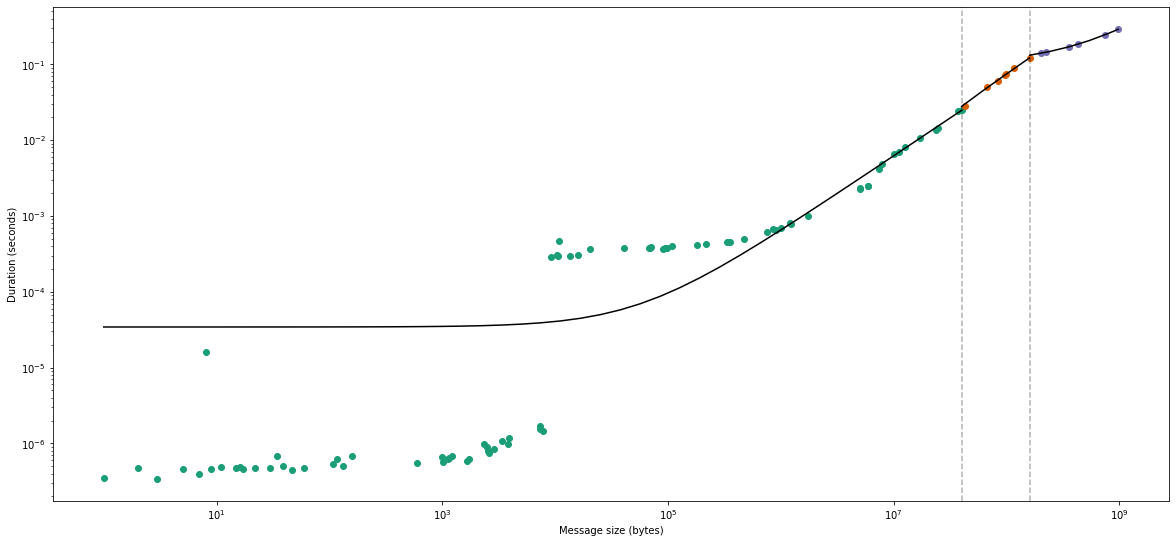

In [13]:
def draw_plot(reg, alpha=1):
    reg.plot_dataset(log=True, alpha=alpha)
    plt.xlabel('Message size (bytes)')
    plt.ylabel('Duration (seconds)')

draw_plot(reg_send)

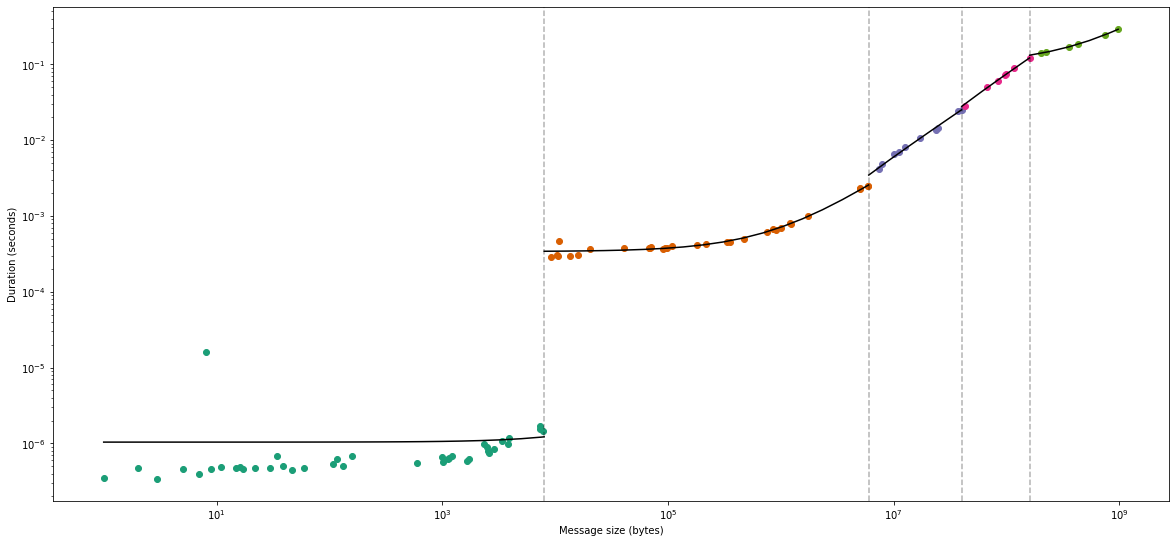

In [14]:
breakpoints_send = [8000, 6e6, 39939081, 160097505]
draw_plot(pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints_send))
breakpoints_send = set(breakpoints_send)

### MPI_Isend

In [15]:
tmp = aggregate_dataframe(remote['isend'])
reg_isend = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_isend.breakpoints)
reg_isend

[15798, 61596, 25824978]


-inf < x ≤ 1.580e+04
	y ~ 8.631e-11x + 8.998e-07
1.580e+04 < x ≤ 6.160e+04
	y ~ 3.022e-11x + 4.214e-06
6.160e+04 < x ≤ 2.582e+07
	y ~ 3.244e-14x + 1.156e-06
2.582e+07 < x ≤ inf
	y ~ 3.437e-16x + 3.177e-06

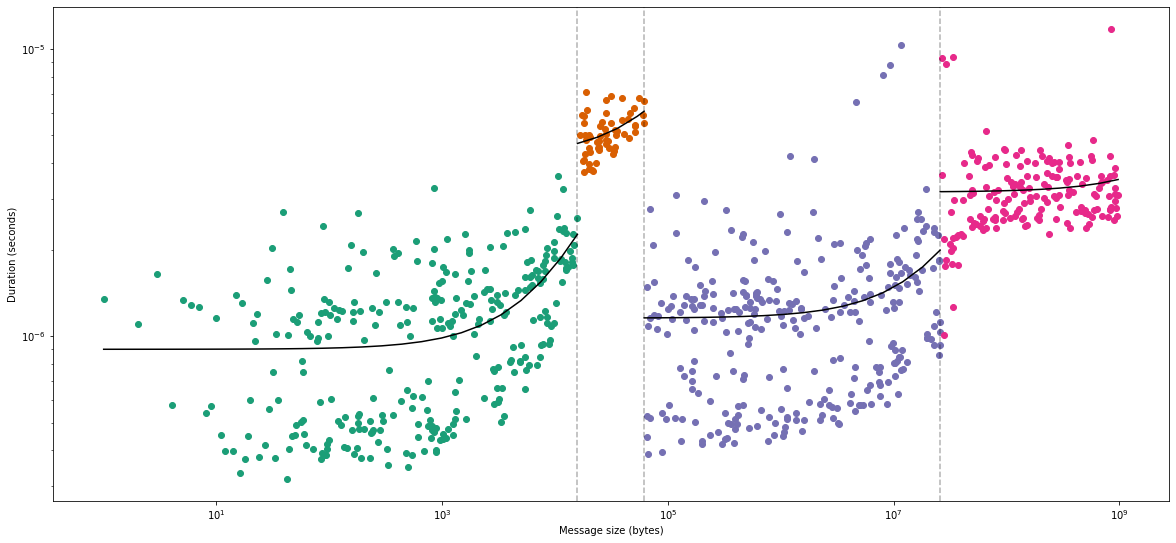

In [16]:
draw_plot(reg_isend)

In [17]:
breakpoints_isend = set(reg_isend.breakpoints)
breakpoints_isend

{15798, 61596, 25824978}

### MPI_Recv

In [18]:
tmp = ring['recv']
tmp = aggregate_dataframe(tmp[tmp['experiment'] == 'remote'])
reg_recv = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration)
print(reg_recv.breakpoints)
reg_recv = reg_recv.auto_simplify()
print(reg_recv.breakpoints)
reg_recv

[9129, 40764, 5071583, 5951087, 42672591, 160097505]
[42672591, 160097505]


-inf < x ≤ 4.267e+07
	y ~ 5.656e-10x + -1.613e-04
4.267e+07 < x ≤ 1.601e+08
	y ~ 7.787e-10x + -5.428e-03
1.601e+08 < x ≤ inf
	y ~ 2.032e-10x + 9.321e-02

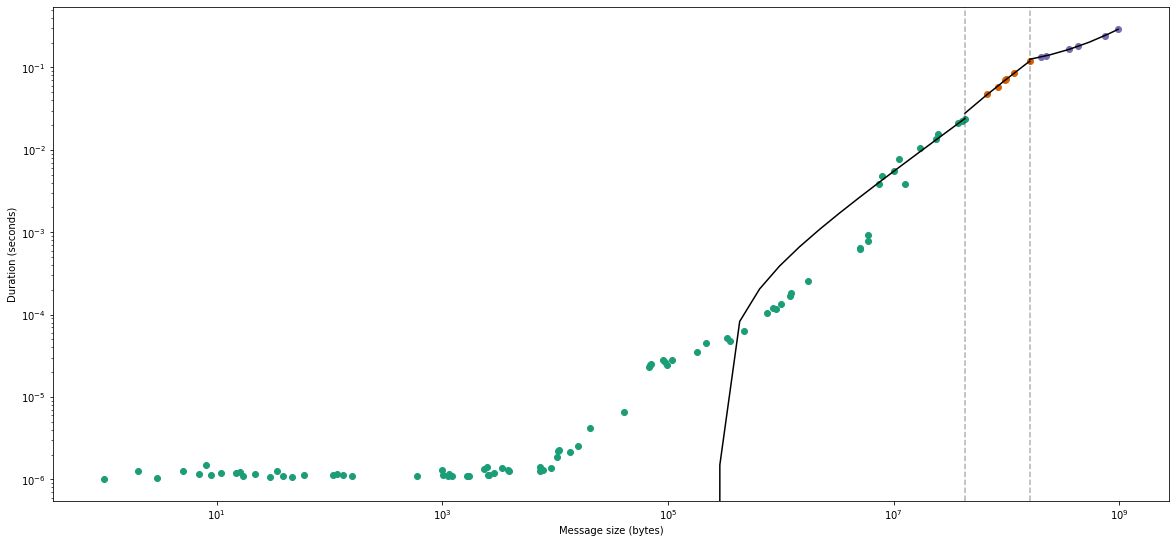

In [19]:
draw_plot(reg_recv)

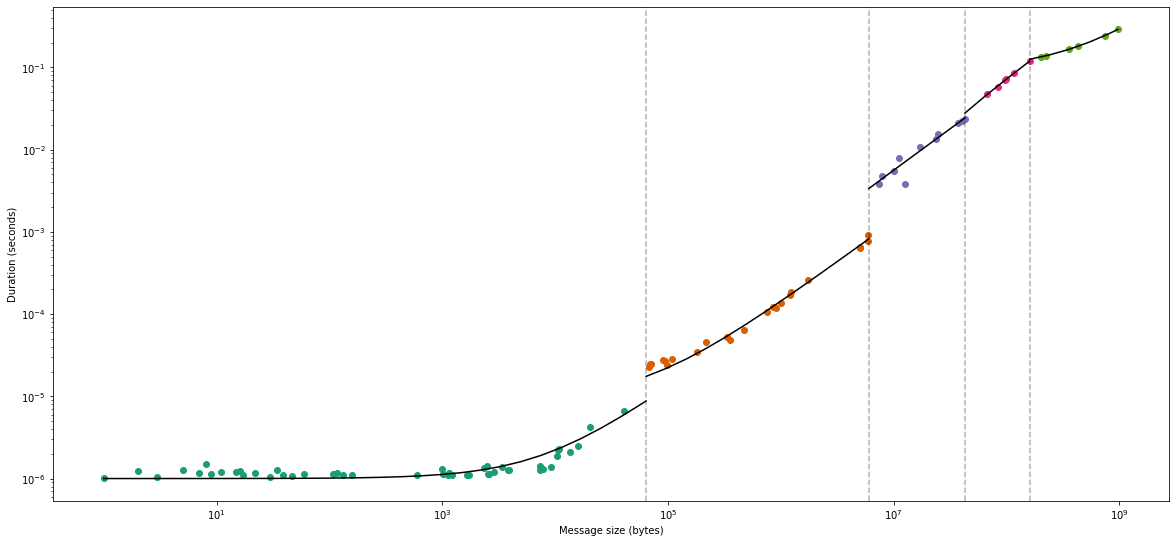

In [20]:
breakpoints_recv = list(sorted(set(reg_recv.breakpoints) | {64000, 6e6}))
draw_plot(pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints_recv))
breakpoints_recv = set(breakpoints_recv)

### Pingpong

In [21]:
tmp = ring['ringrong']
tmp = aggregate_dataframe(tmp[tmp['experiment'] == 'remote'])
reg_pingpong = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration)
print(reg_pingpong.breakpoints)
reg_pingpong = reg_pingpong.auto_simplify()
print(reg_pingpong.breakpoints)
reg_pingpong

[7749, 5951087, 42672591, 160097505]
[5951087, 42672591, 160097505]


-inf < x ≤ 5.951e+06
	y ~ 5.605e-10x + 1.278e-04
5.951e+06 < x ≤ 4.267e+07
	y ~ 1.230e-09x + -7.310e-04
4.267e+07 < x ≤ 1.601e+08
	y ~ 1.545e-09x + -6.941e-03
1.601e+08 < x ≤ inf
	y ~ 3.974e-10x + 1.942e-01

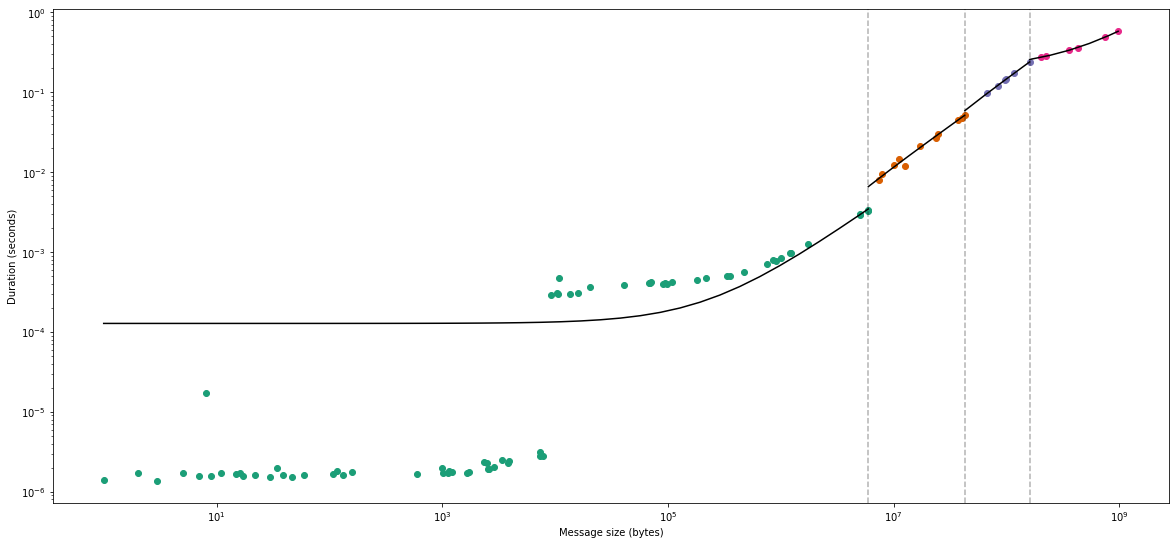

In [22]:
draw_plot(reg_pingpong)

[8000, 5951087, 42672591, 160097505]


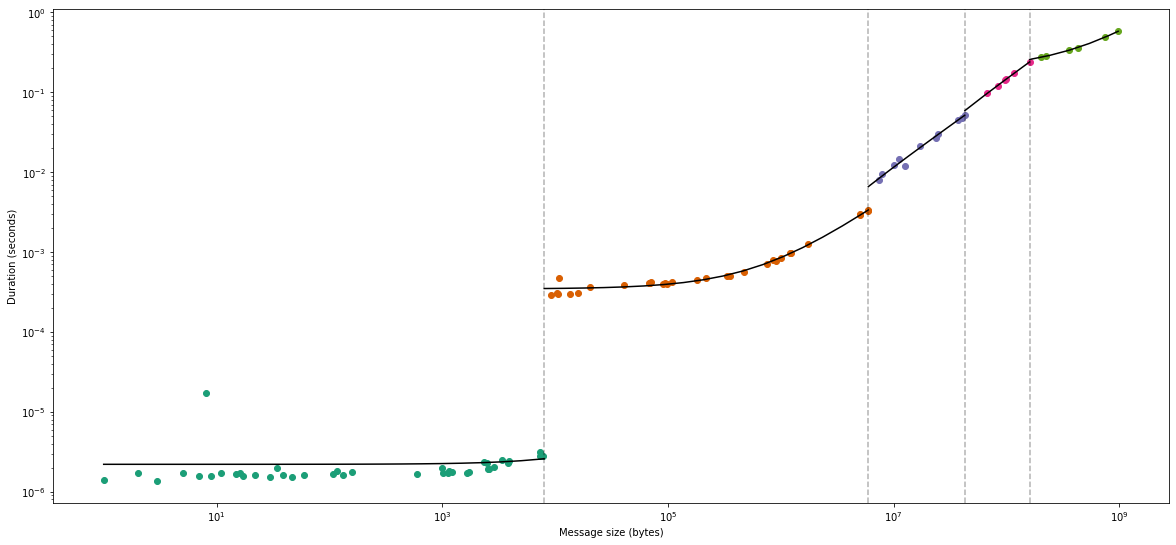

In [23]:
breakpoints_pingpong = list(sorted((set(reg_pingpong.breakpoints) | {8000})))
draw_plot(pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints_pingpong))
print(breakpoints_pingpong)
breakpoints_pingpong = set(breakpoints_pingpong)

## Better regressions

Let's use the same breakpoints everywhere.

In [24]:
breakpoints = [int(b) for b in sorted(set.union(breakpoints_send, breakpoints_isend, breakpoints_recv, breakpoints_pingpong))]
breakpoints

[8000,
 15798,
 61596,
 64000,
 5951087,
 6000000,
 25824978,
 39939081,
 42672591,
 160097505]

In [25]:
remove = {61596, 5951087, 25824978, 39939081}
breakpoints = [b for b in breakpoints if b not in remove]
assert threshold in breakpoints
breakpoints

[8000, 15798, 64000, 6000000, 42672591, 160097505]

In [26]:
def my_join(*values, inner_sep=':', outer_sep=';'):
    result = []
    for items in zip(*values):
        result.append(inner_sep.join([str(it) for it in items]))
    return outer_sep.join(result)

def regression_to_str(reg_df, drop_threshold=None, keys=['intercept', 'coefficient']):
    if drop_threshold is not None:
        reg_df.loc[reg_df.min_x >= drop_threshold, 'intercept'] = 0
        reg_df.loc[reg_df.min_x >= drop_threshold, 'coefficient'] = 0
    reg_df.loc[reg_df.min_x < 0, 'min_x'] = 0
    reg_df.min_x = reg_df.min_x.astype(int)
    reg_df.loc[reg_df.coefficient < 0, 'coefficient'] = 0
    reg_df.loc[reg_df.intercept < 0, 'intercept'] = 0
    reg_df.sort_values(by='min_x')
    values = [reg_df.min_x]
    for key in keys:
        values.append(reg_df[key])
    return my_join(*values)

### MPI_Send

-inf < x ≤ 8.000e+03
	y ~ 2.258e-11x + 1.039e-06
8.000e+03 < x ≤ 1.580e+04
	y ~ -1.438e-09x + 3.468e-04
1.580e+04 < x ≤ 6.400e+04
	y ~ 2.301e-09x + 2.889e-04
6.400e+04 < x ≤ 6.000e+06
	y ~ 3.705e-10x + 3.434e-04
6.000e+06 < x ≤ 4.267e+07
	y ~ 6.608e-10x + -6.697e-04
4.267e+07 < x ≤ 1.601e+08
	y ~ 7.665e-10x + -1.513e-03
1.601e+08 < x ≤ inf
	y ~ 1.943e-10x + 1.010e-01


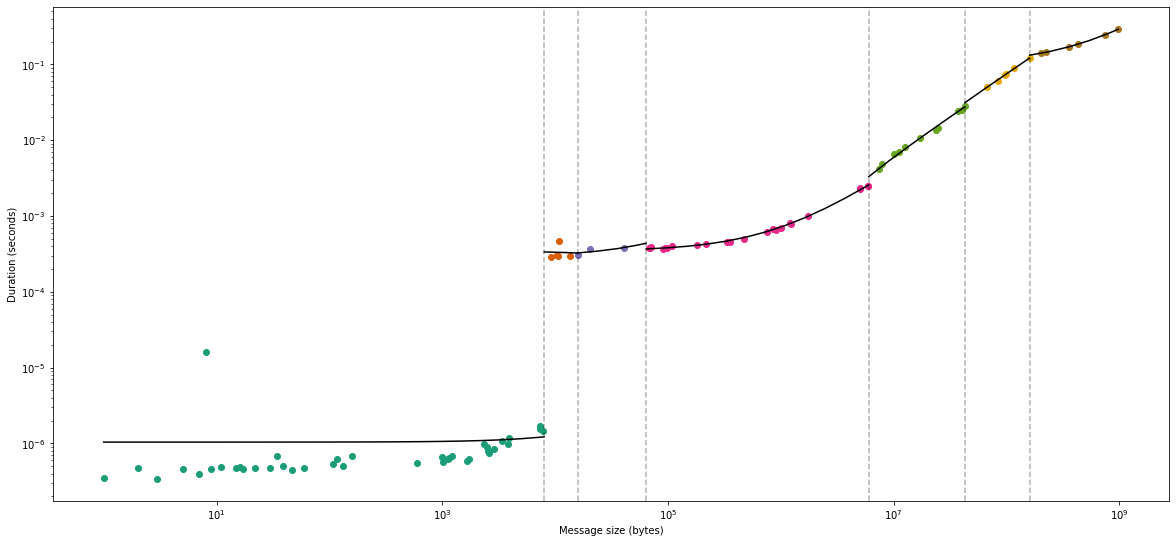

In [27]:
tmp = ring['send']
tmp = aggregate_dataframe(tmp[tmp['experiment'] == 'remote'])
reg_send = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_send)
draw_plot(reg_send)

In [28]:
reg_send_str = regression_to_str(reg_send.to_pandas(), drop_threshold=threshold)
reg_send_str

'0:1.0390044058501086e-06:2.2582693391522874e-11;8000:0.0003468233639105082:0.0;15798:0.0002888553072948145:2.3011264127198946e-09;64000:0.0:0.0;6000000:0.0:0.0;42672591:0.0:0.0;160097505:0.0:0.0'

### MPI_Isend

-inf < x ≤ 8.000e+03
	y ~ 7.635e-11x + 9.114e-07
8.000e+03 < x ≤ 1.580e+04
	y ~ 1.016e-10x + 7.533e-07
1.580e+04 < x ≤ 6.400e+04
	y ~ 3.022e-11x + 4.214e-06
6.400e+04 < x ≤ 6.000e+06
	y ~ 5.530e-14x + 1.098e-06
6.000e+06 < x ≤ 4.267e+07
	y ~ 4.633e-14x + 1.168e-06
4.267e+07 < x ≤ 1.601e+08
	y ~ 5.115e-16x + 3.151e-06
1.601e+08 < x ≤ inf
	y ~ 2.554e-16x + 3.233e-06


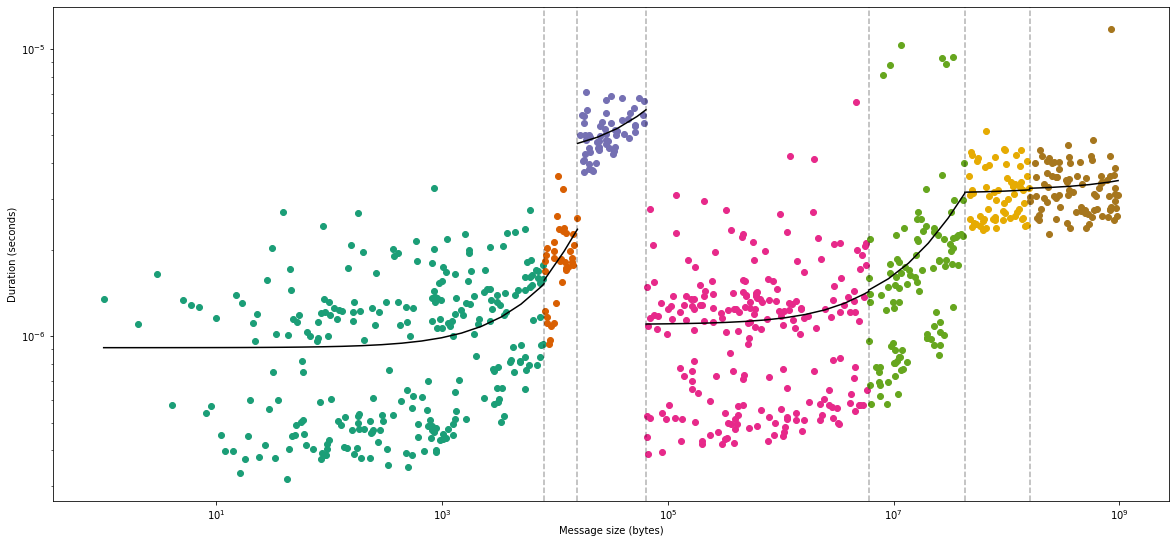

In [29]:
tmp = aggregate_dataframe(remote['isend'])
reg_isend = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_isend)
draw_plot(reg_isend)

In [30]:
reg_isend_str = regression_to_str(reg_isend.to_pandas())
reg_isend_str

'0:9.114127576191782e-07:7.635116667577744e-11;8000:7.532902626587861e-07:1.0157330626986557e-10;15798:4.213616239765202e-06:3.022067854930598e-11;64000:1.0982098510875872e-06:5.530436066901923e-14;6000000:1.167813671168556e-06:4.632525436311795e-14;42672591:3.151147394741291e-06:5.11470100892252e-16;160097505:3.232961654323926e-06:2.553537399274677e-16'

### MPI_Recv

-inf < x ≤ 8.000e+03
	y ~ 2.541e-11x + 1.161e-06
8.000e+03 < x ≤ 1.580e+04
	y ~ 1.371e-10x + 4.813e-07
1.580e+04 < x ≤ 6.400e+04
	y ~ 1.491e-10x + 6.405e-07
6.400e+04 < x ≤ 6.000e+06
	y ~ 1.353e-10x + 8.867e-06
6.000e+06 < x ≤ 4.267e+07
	y ~ 5.697e-10x + -6.135e-05
4.267e+07 < x ≤ 1.601e+08
	y ~ 7.787e-10x + -5.428e-03
1.601e+08 < x ≤ inf
	y ~ 2.032e-10x + 9.321e-02


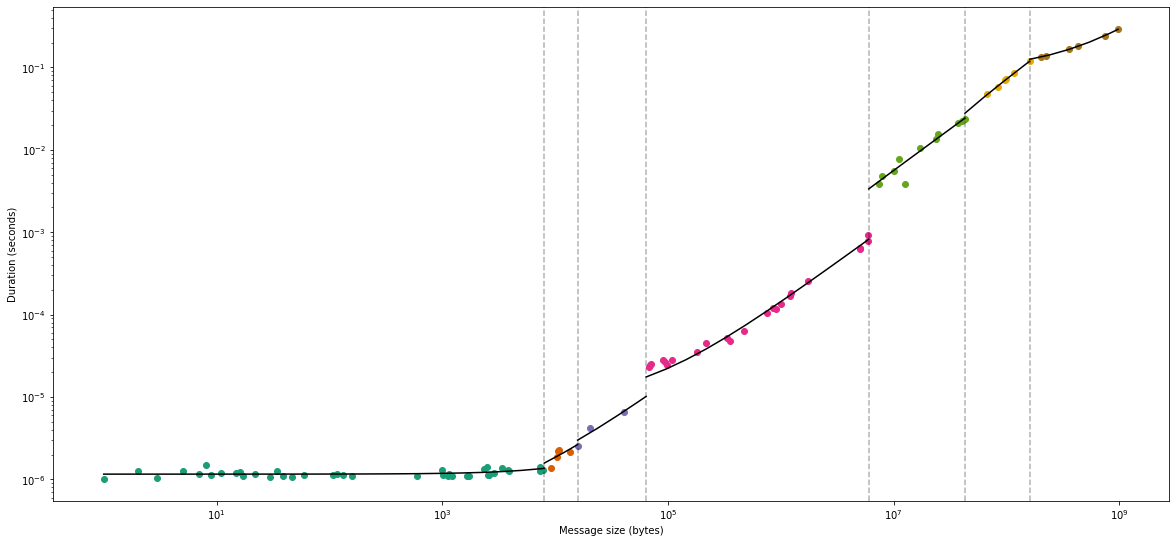

In [31]:
tmp = ring['recv']
tmp = aggregate_dataframe(tmp[tmp['experiment'] == 'remote'])
reg_recv = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_recv)
draw_plot(reg_recv)

In [32]:
reg_recv_str = regression_to_str(reg_recv.to_pandas(), drop_threshold=threshold)
reg_recv_str

'0:1.1606281334276814e-06:2.5405126421726545e-11;8000:4.813055334777501e-07:1.3709188743427587e-10;15798:6.405086625588439e-07:1.4914447755480297e-10;64000:0.0:0.0;6000000:0.0:0.0;42672591:0.0:0.0;160097505:0.0:0.0'

### Pingpong

-inf < x ≤ 8.000e+03
	y ~ 4.799e-11x + 2.200e-06
8.000e+03 < x ≤ 1.580e+04
	y ~ -1.301e-09x + 3.473e-04
1.580e+04 < x ≤ 6.400e+04
	y ~ 2.450e-09x + 2.895e-04
6.400e+04 < x ≤ 6.000e+06
	y ~ 5.058e-10x + 3.523e-04
6.000e+06 < x ≤ 4.267e+07
	y ~ 1.230e-09x + -7.310e-04
4.267e+07 < x ≤ 1.601e+08
	y ~ 1.545e-09x + -6.941e-03
1.601e+08 < x ≤ inf
	y ~ 3.974e-10x + 1.942e-01


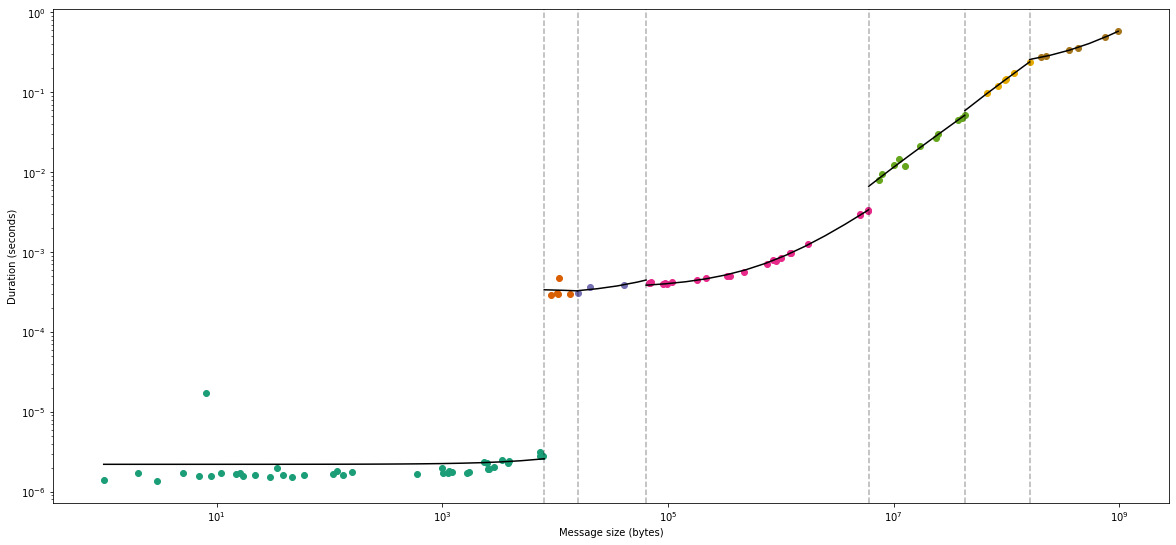

In [33]:
tmp = ring['ringrong']
tmp = aggregate_dataframe(tmp[tmp['experiment'] == 'remote'])
reg_pingpong = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_pingpong)
draw_plot(reg_pingpong)

In [34]:
df_reg_recv = reg_recv.to_pandas()
df_reg_pingpong = reg_pingpong.to_pandas()
df_reg_transfer = df_reg_pingpong[['coefficient', 'intercept', 'max_x', 'min_x']].copy()
df_reg_transfer['coefficient'] /= 2
df_reg_transfer['intercept'] /= 2
df_reg_transfer.loc[df_reg_transfer['max_x'] <= threshold, 'coefficient'] -= df_reg_recv[df_reg_recv['max_x'] <= threshold]['coefficient']
df_reg_transfer.loc[df_reg_transfer['max_x'] <= threshold, 'intercept'] -= df_reg_recv[df_reg_recv['max_x'] <= threshold]['intercept']
# A negative bandwidth or latency does not make sense 
df_reg_transfer.loc[df_reg_transfer['coefficient'] < 0, 'coefficient'] = 1/expected_bandwidth
df_reg_transfer.loc[df_reg_transfer['intercept'] < 0, 'intercept'] = 0
df_reg_transfer

,coefficient,intercept,max_x,min_x
0,8.000000e-11,0.000000,8000.0,-inf
1,8.000000e-11,0.000173,15798.0,8000.0
2,1.075991e-09,0.000144,64000.0,15798.0
3,2.528962e-10,0.000176,6000000.0,64000.0
4,6.152294e-10,0.000000,42672591.0,6000000.0
5,7.725930e-10,0.000000,160097505.0,42672591.0
6,1.987136e-10,0.097091,inf,160097505.0


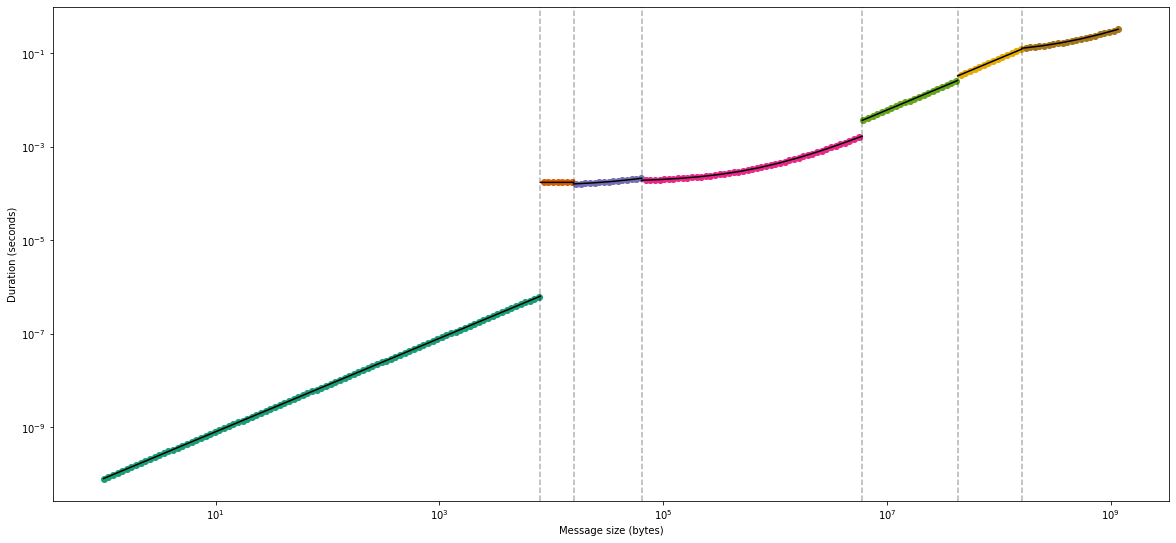

In [35]:
def predict(reg, x):
    for row in reg.iterrows():
        _, row = row
        if row.min_x <= x < row.max_x:
            return row.coefficient * x + row.intercept

tmp = pandas.DataFrame({'x': [1.1**i for i in range(220)]})
tmp['y'] = tmp.apply(lambda row: predict(df_reg_transfer, row.x), axis=1)
draw_plot(pytree.compute_regression(x=tmp.x, y=tmp.y, breakpoints=breakpoints))

In [36]:
df_reg_transfer['bandwidth_factor'] = 1/(df_reg_transfer.coefficient*expected_bandwidth)
df_reg_transfer['latency_factor']   = df_reg_transfer.intercept/expected_latency

pandas.set_option('display.float_format', lambda x: '%.2e' % x)
df_reg_transfer

,coefficient,intercept,max_x,min_x,bandwidth_factor,latency_factor
0,8.00e-11,0.00e+00,8.00e+03,-inf,1.00e+00,0.00e+00
1,8.00e-11,1.73e-04,1.58e+04,8.00e+03,1.00e+00,1.73e+03
2,1.08e-09,1.44e-04,6.40e+04,1.58e+04,7.44e-02,1.44e+03
3,2.53e-10,1.76e-04,6.00e+06,6.40e+04,3.16e-01,1.76e+03
4,6.15e-10,0.00e+00,4.27e+07,6.00e+06,1.30e-01,0.00e+00
5,7.73e-10,0.00e+00,1.60e+08,4.27e+07,1.04e-01,0.00e+00
6,1.99e-10,9.71e-02,inf,1.60e+08,4.03e-01,9.71e+05


In [37]:
bandwidth_str = regression_to_str(df_reg_transfer, drop_threshold=threshold, keys=['bandwidth_factor'])
latency_str = regression_to_str(df_reg_transfer, drop_threshold=threshold, keys=['latency_factor'])

print(bandwidth_str)
print(latency_str)

min_lat_factor = df_reg_transfer[df_reg_transfer.min_x == float('-inf')].latency_factor.min()
max_bw_factor = df_reg_transfer[df_reg_transfer.max_x == float('inf')].bandwidth_factor.max()

0:1.0000000000000002;8000:1.0000000000000002;15798:0.07435006650635523;64000:0.3163352696348148;6000000:0.13003278960133288;42672591:0.10354740223279707;160097505:0.40258935729656503
0:0.0;8000:1731.7102918851567;15798:1441.073993161278;64000:1761.4784830658123;6000000:0.0;42672591:0.0;160097505:970913.4558162984


### Wtime

1.3269380952380954e-06


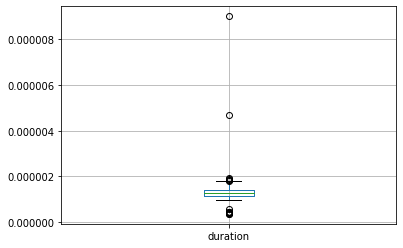

In [38]:
wtime_mean = remote['wtime'].duration.mean()
print(wtime_mean)
remote['wtime'].boxplot('duration')

### Test

8.273395731280616e-07


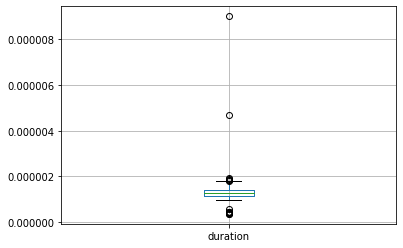

In [39]:
test_mean = remote['test'].duration.mean()
print(test_mean)
remote['wtime'].boxplot('duration')

### Iprobe

2.5197820823244545e-07


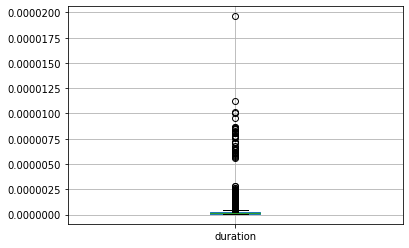

In [40]:
iprobe_mean = remote['iprobe'].duration.mean()
print(iprobe_mean)
remote['iprobe'].boxplot('duration')

## Loopback

In the next cells, we will compute the bandwidth and latency factors for the loopback. We will use the same `os`, `or` and `ois` values than for the remote communications however.

In [41]:
tmp = ring['ringrong']
tmp = aggregate_dataframe(tmp[tmp['experiment'] == 'loopback'])
reg_pingpong_loopback = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration)
print(reg_pingpong_loopback.breakpoints)
reg_pingpong_loopback = reg_pingpong_loopback.auto_simplify()
print(reg_pingpong_loopback.breakpoints)
reg_pingpong_loopback

[7318, 7749, 15811, 109380, 23456493, 36900419, 160097505]
[36900419, 160097505]


-inf < x ≤ 3.690e+07
	y ~ 8.604e-10x + -1.585e-04
3.690e+07 < x ≤ 1.601e+08
	y ~ 1.868e-09x + -1.312e-02
1.601e+08 < x ≤ inf
	y ~ 4.587e-10x + 2.036e-01

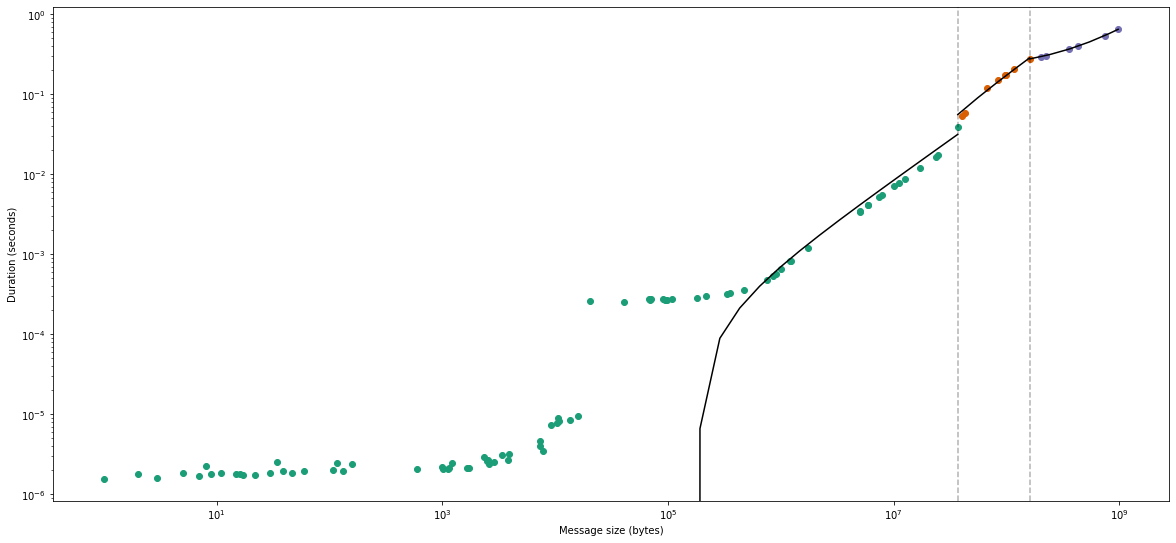

In [42]:
draw_plot(reg_pingpong_loopback)

[16000, 6000000.0, 36900419, 160097505]


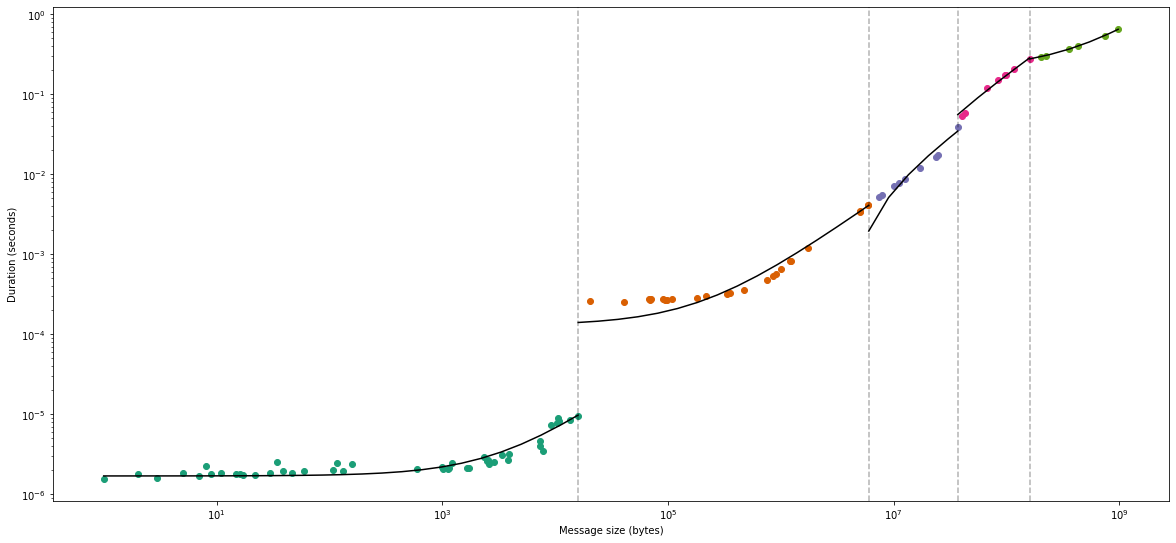

In [43]:
breakpoints_pingpong_loopback = list(sorted((set(reg_pingpong_loopback.breakpoints) | {16000, 6e6}) - {42}))
reg_pingpong_loopback = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints_pingpong_loopback)
draw_plot(reg_pingpong_loopback)
print(breakpoints_pingpong_loopback)

In [44]:
df_reg_pingpong_loopback = reg_pingpong_loopback.to_pandas()
df_reg_transfer_loopback = df_reg_pingpong_loopback[['coefficient', 'intercept', 'max_x', 'min_x']].copy()
df_reg_transfer_loopback['coefficient'] /= 2
df_reg_transfer_loopback['intercept'] /= 2
df_reg_transfer_loopback.loc[df_reg_transfer_loopback['max_x'] <= threshold, 'coefficient'] -= df_reg_recv[df_reg_recv['max_x'] <= threshold]['coefficient']
df_reg_transfer_loopback.loc[df_reg_transfer_loopback['max_x'] <= threshold, 'intercept'] -= df_reg_recv[df_reg_recv['max_x'] <= threshold]['intercept']

# A negative bandwidth or latency does not make sense 
df_reg_transfer_loopback.loc[df_reg_transfer_loopback['coefficient'] < 0, 'coefficient'] = 1/expected_loopback_bandwidth
df_reg_transfer_loopback.loc[df_reg_transfer_loopback['intercept'] < 0, 'intercept'] = 0
df_reg_transfer_loopback

,coefficient,intercept,max_x,min_x
0,2.27e-10,0.00e+00,1.60e+04,-inf
1,3.30e-10,6.50e-05,6.00e+06,1.60e+04
2,5.30e-10,0.00e+00,3.69e+07,6.00e+06
3,9.34e-10,0.00e+00,1.60e+08,3.69e+07
4,2.29e-10,1.02e-01,inf,1.60e+08


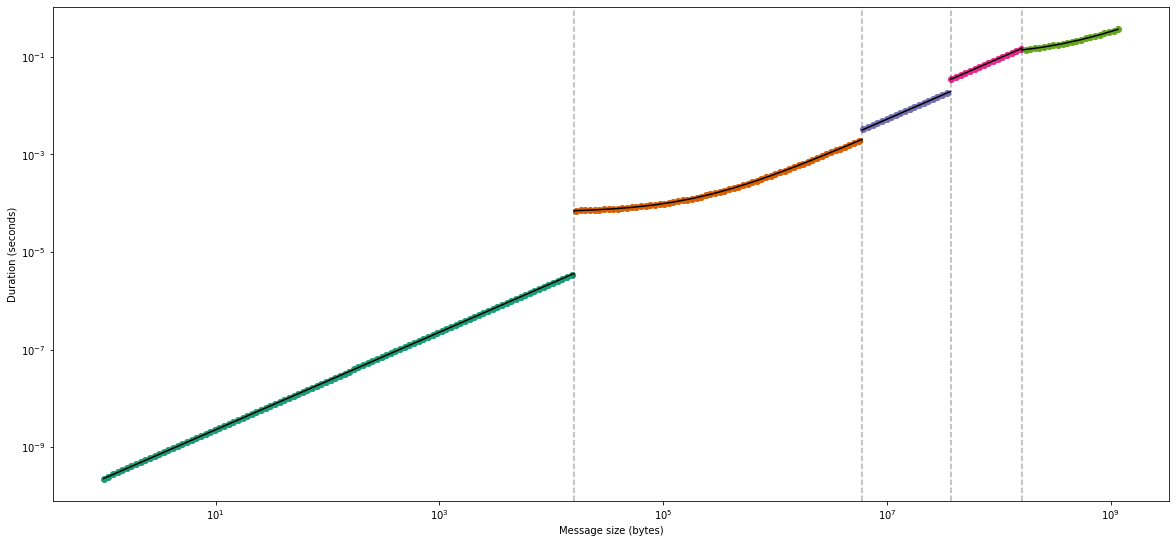

In [45]:
tmp = pandas.DataFrame({'x': [1.1**i for i in range(220)]})
tmp['y'] = tmp.apply(lambda row: predict(df_reg_transfer_loopback, row.x), axis=1)
draw_plot(pytree.compute_regression(x=tmp.x, y=tmp.y, breakpoints=breakpoints_pingpong_loopback))

In [46]:
df_reg_transfer_loopback['bandwidth_factor'] = 1/(df_reg_transfer_loopback.coefficient*expected_loopback_bandwidth)
df_reg_transfer_loopback['latency_factor']   = df_reg_transfer_loopback.intercept/expected_loopback_latency

pandas.set_option('display.float_format', lambda x: '%.2e' % x)
df_reg_transfer_loopback

,coefficient,intercept,max_x,min_x,bandwidth_factor,latency_factor
0,2.27e-10,0.00e+00,1.60e+04,-inf,1.76e-01,0.00e+00
1,3.30e-10,6.50e-05,6.00e+06,1.60e+04,1.21e-01,6.50e+02
2,5.30e-10,0.00e+00,3.69e+07,6.00e+06,7.55e-02,0.00e+00
3,9.34e-10,0.00e+00,1.60e+08,3.69e+07,4.28e-02,0.00e+00
4,2.29e-10,1.02e-01,inf,1.60e+08,1.74e-01,1.02e+06


In [47]:
loopback_bandwidth_str = regression_to_str(df_reg_transfer_loopback, drop_threshold=threshold, keys=['bandwidth_factor'])
loopback_latency_str = regression_to_str(df_reg_transfer_loopback, drop_threshold=threshold, keys=['latency_factor'])

print(loopback_bandwidth_str)
print(loopback_latency_str)

0:0.17591906192813994;16000:0.12119203247138953;6000000:0.07551057012803415;36900419:0.04281516758309203;160097505:0.17440518795992602
0:0.0;16000:650.2212383180362;6000000:0.0;36900419:0.0;160097505:1017885.3518765072


## XML generation

In [48]:
config = f'''
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="{reg_send_str}"/>
        <prop id="smpi/or" value="{reg_recv_str}"/>
        <prop id="smpi/ois" value="{reg_isend_str}"/>
        <prop id="smpi/bw-factor" value="{bandwidth_str}"/>
        <prop id="smpi/lat-factor" value="{latency_str}"/>
        <prop id="smpi/loopback-bw-factor" value="{loopback_bandwidth_str}"/>
        <prop id="smpi/loopback-lat-factor" value="{loopback_latency_str}"/>
        <prop id="smpi/async-small-thresh" value="{threshold}"/>
        <prop id="smpi/send-is-detached-thresh" value="{threshold}"/>
        <prop id="smpi/iprobe" value="{iprobe_mean}"/>
        <prop id="smpi/test" value="{test_mean}"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="1-32" speed="1" core="32" bw="{expected_bandwidth*1e-9}GBps" lat="{expected_latency*1e6:.2f}us" loopback_bw="{expected_loopback_bandwidth*1e-9}GBps" loopback_lat="{expected_loopback_latency*1e6:.2f}us"/>
    </AS>
</platform>
'''

# Note: I removed the wtime property because I do not need it, feel free to add it back: <prop id="smpi/wtime" value="{wtime_mean}"/>

from IPython.display import display, Markdown
display(Markdown('```xml\n%s\n```' % config))

```xml

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:1.0390044058501086e-06:2.2582693391522874e-11;8000:0.0003468233639105082:0.0;15798:0.0002888553072948145:2.3011264127198946e-09;64000:0.0:0.0;6000000:0.0:0.0;42672591:0.0:0.0;160097505:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.1606281334276814e-06:2.5405126421726545e-11;8000:4.813055334777501e-07:1.3709188743427587e-10;15798:6.405086625588439e-07:1.4914447755480297e-10;64000:0.0:0.0;6000000:0.0:0.0;42672591:0.0:0.0;160097505:0.0:0.0"/>
        <prop id="smpi/ois" value="0:9.114127576191782e-07:7.635116667577744e-11;8000:7.532902626587861e-07:1.0157330626986557e-10;15798:4.213616239765202e-06:3.022067854930598e-11;64000:1.0982098510875872e-06:5.530436066901923e-14;6000000:1.167813671168556e-06:4.632525436311795e-14;42672591:3.151147394741291e-06:5.11470100892252e-16;160097505:3.232961654323926e-06:2.553537399274677e-16"/>
        <prop id="smpi/bw-factor" value="0:1.0000000000000002;8000:1.0000000000000002;15798:0.07435006650635523;64000:0.3163352696348148;6000000:0.13003278960133288;42672591:0.10354740223279707;160097505:0.40258935729656503"/>
        <prop id="smpi/lat-factor" value="0:0.0;8000:1731.7102918851567;15798:1441.073993161278;64000:1761.4784830658123;6000000:0.0;42672591:0.0;160097505:970913.4558162984"/>
        <prop id="smpi/loopback-bw-factor" value="0:0.17591906192813994;16000:0.12119203247138953;6000000:0.07551057012803415;36900419:0.04281516758309203;160097505:0.17440518795992602"/>
        <prop id="smpi/loopback-lat-factor" value="0:0.0;16000:650.2212383180362;6000000:0.0;36900419:0.0;160097505:1017885.3518765072"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.5197820823244545e-07"/>
        <prop id="smpi/test" value="8.273395731280616e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="1-32" speed="1" core="32" bw="12.5GBps" lat="0.10us" loopback_bw="25.0GBps" loopback_lat="0.10us"/>
    </AS>
</platform>

```

## Pretty plots

In [49]:
def pretty_plot(df, reg, n=10000):
    df = df.sample(n=n).copy()
    df['pred'] = df.apply(lambda row: reg.predict(row['msg_size']), axis=1)
    df['group'] = 0
    for i, bp in enumerate(reg.breakpoints):
        df.loc[df['msg_size'] > bp, 'group'] = i+1
    plot = ggplot(df) + geom_point(aes(x='msg_size', y='duration', color='factor(group)'), alpha=0.5, show_legend=False)
    breakpoints = list(reg.breakpoints)
    for bp in breakpoints:
        plot = plot + geom_vline(xintercept=bp, linetype='dashed', color='gray')
    breakpoints = [float('-inf')] + breakpoints + [float('inf')]
    for bp1, bp2 in zip(breakpoints[:-1], breakpoints[1:]):
        plot = plot + geom_line(df[(df.msg_size > bp1) & (df.msg_size < bp2)], aes(x='msg_size', y='pred'), size=1)
    plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + xlab('Message size (bytes)') + ylab('Duration (seconds)')
    op = df['op'].unique()[0]
    plot = plot + ggtitle('Durations of %s' % op)
    return plot

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/recv.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


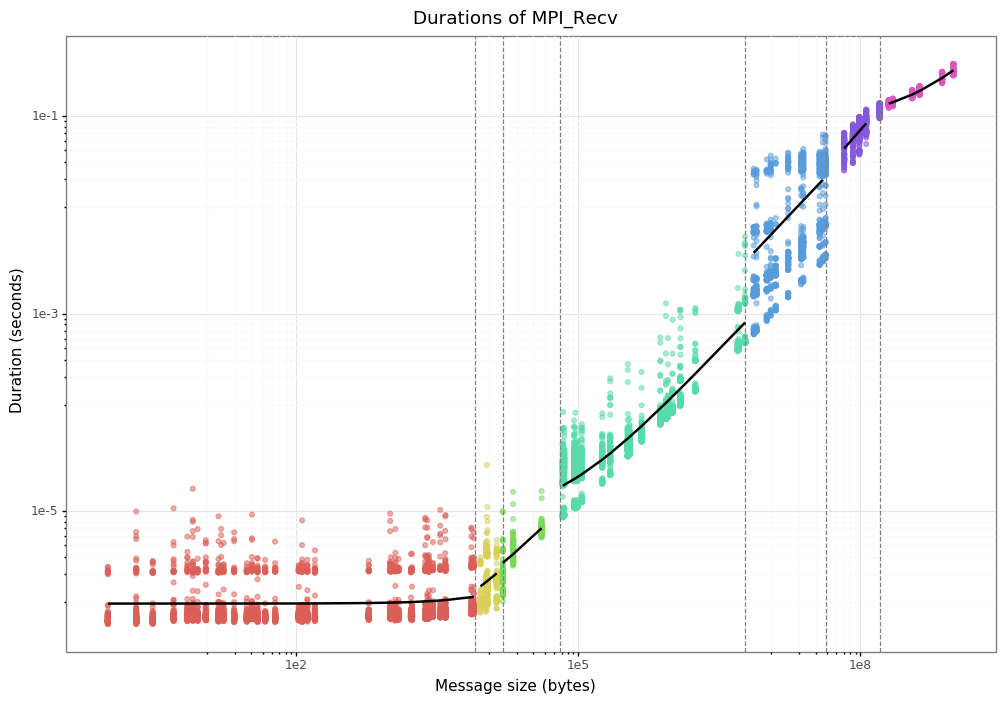

<ggplot: (-9223363245742596201)>

In [50]:
tmp = ring['recv']
tmp = tmp[tmp['experiment'] == 'remote'].copy()
tmp['op'] = tmp['function']
plot = pretty_plot(tmp, reg_recv)
plot.save('/tmp/recv.pdf')
plot

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/send.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


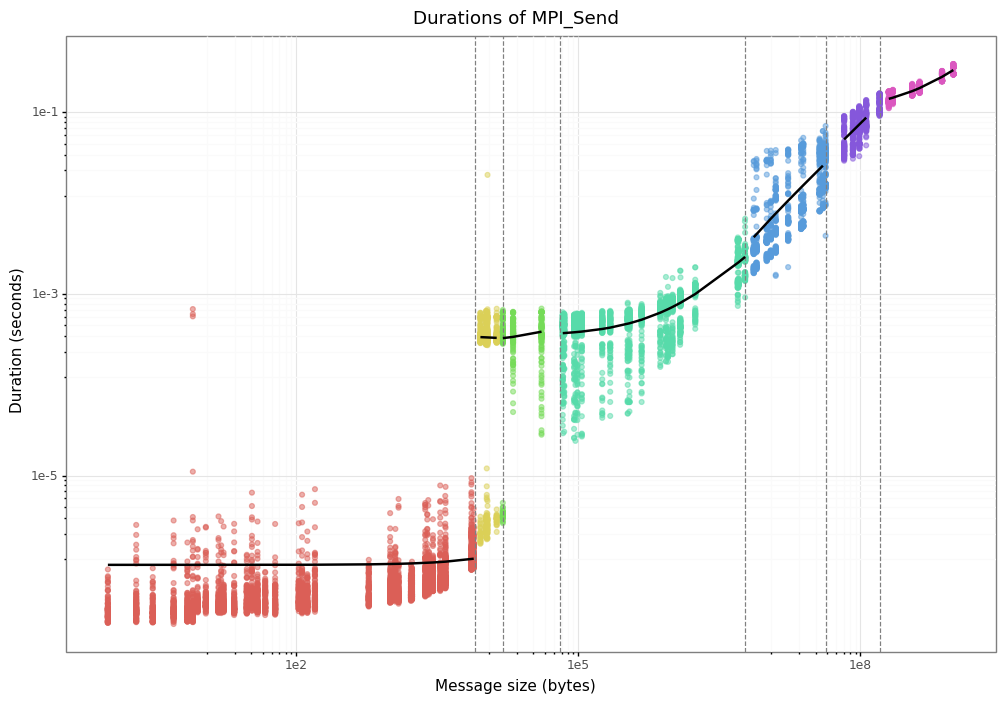

<ggplot: (8791112121962)>

In [51]:
tmp = ring['send']
tmp = tmp[tmp['experiment'] == 'remote'].copy()
tmp['op'] = tmp['function']
plot = pretty_plot(tmp, reg_send)
plot.save('/tmp/send.pdf')
plot